<h1 align="center"> Credit Fraud Detector </h1>

## Check Dataset

In [1]:
# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
from sklearn.model_selection import train_test_split


df = pd.read_csv('../input/creditcard.csv')
df.head()

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [3]:
# Good No Null Values!
df.isnull().sum().max()

0

In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<h1 align="center"> Simulation </h1>

## Define test dataframe

In [6]:
# df3 : 從原始的 data DataFrame 中抽出 10% 的數據 作為測試答案
# new_df : 剩餘 90% 的數據
data, df3 = train_test_split(df, test_size=0.1, random_state=42)

# 檢查 df3 和 data 的形狀
print("df3 的形狀：", df3.shape)
print("data 的形狀：", data.shape)

df3 的形狀： (28481, 31)
data 的形狀： (256326, 31)


## Bank Initial Threshold Setting

A 的閾值是 :  153.9882968894364  元


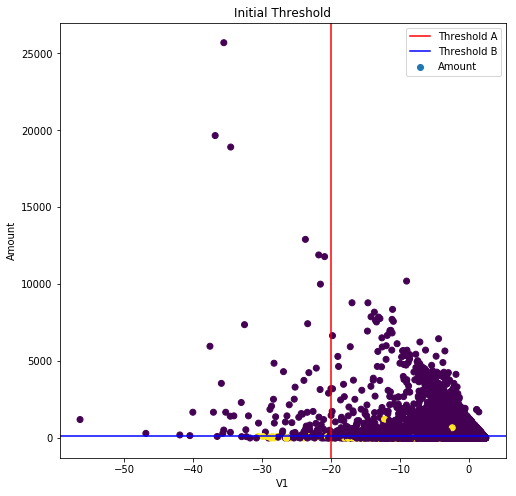

In [7]:
# 設定特徵A的閾值為threshold_A，特徵B的閾值為threshold_B

threshold_A = -20 #V1的50%
threshold_B = 5000/32.47 #Amount>=5000
print("A 的閾值是 : ",threshold_B," 元")

# 將label指定給顏色
colors = data['Class']

plt.figure(figsize=(8, 8))  # 設定圖片大小

plt.scatter(data['V1'], data['Amount'], c=colors)
plt.xlabel('V1')
plt.ylabel('Amount')
plt.title('Initial Threshold')
plt.axvline(x=threshold_A, color='r', linestyle='-', label='Threshold A')  # 加入圖例
plt.axhline(y=threshold_B, color='b', linestyle='-', label='Threshold B')  # 加入圖例

plt.legend()  # 顯示圖例

plt.show()

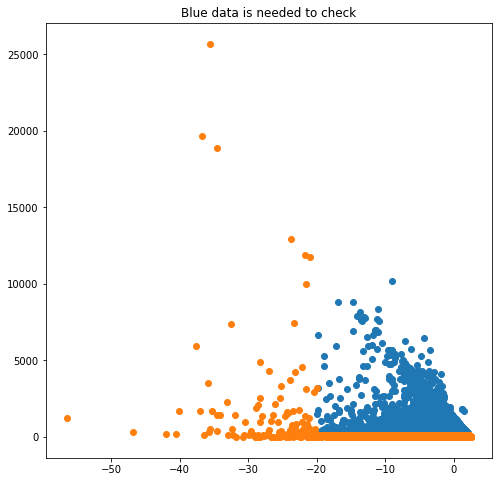

In [8]:
# df1 : 被審查的資料，閾值內資料，只包含特徵A大於閾值且特徵B大於閾值的資料
df1 = data.query('V1 >= @threshold_A and Amount >= @threshold_B')

# df2 : 未被審查的資料，閾值外資料，只包含特徵A小於閾值且特徵B小於閾值的資料
df2 = data.query('V1 < @threshold_A or Amount < @threshold_B')

X = df1['V1']
Y = df1['Amount']
colors = df1['Class']
plt.figure(figsize=(8, 8))  # 設定圖片大小
plt.scatter(X, Y)

X = df2['V1']
Y = df2['Amount']
plt.scatter(X, Y)

plt.title('Blue data is needed to check')
plt.show()

In [9]:
df1.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000,34523.000000
mean,93103.686673,-0.568034,-1.571103,-0.368035,0.089288,-0.814185,0.415809,0.523873,-0.156409,-0.081514,-0.162757,-0.035457,0.031939,-0.044465,0.031160,-0.073078,-0.156380,0.031906,0.094200,-0.071441,0.402388,0.135949,-0.003724,-0.034754,-0.022925,-0.011304,0.009109,-0.022499,0.007208,447.846263,0.002491
std,46779.145855,2.249789,2.135504,1.615906,1.499029,1.789096,1.551690,1.843678,1.341487,1.193656,1.055363,1.011609,0.953884,0.939688,0.880525,0.956531,1.038196,0.819626,0.974228,0.892988,1.359387,0.824386,0.784817,1.178122,0.627371,0.601067,0.569104,0.482778,0.453211,498.444409,0.049849
min,1.000000,-19.989586,-29.780328,-17.681072,-5.024097,-40.427726,-17.574835,-31.764946,-73.216718,-7.701499,-14.924655,-4.034718,-17.150405,-5.791881,-14.224404,-4.391307,-13.563273,-23.815636,-9.498746,-4.539840,-19.902611,-34.830382,-7.417140,-44.807735,-2.814898,-10.295397,-1.855355,-9.390980,-8.424041,153.990000,0.000000
25%,51387.000000,-1.516124,-2.076138,-1.273223,-0.867094,-1.512333,-0.473304,-0.418644,-0.310507,-0.886897,-0.743222,-0.820415,-0.425141,-0.658139,-0.391749,-0.693487,-0.759697,-0.413634,-0.509246,-0.616910,-0.024650,-0.098138,-0.496018,-0.361389,-0.356558,-0.335930,-0.370395,-0.127924,-0.033327,200.000000,0.000000
50%,81605.000000,-0.150948,-1.234003,-0.151074,-0.002943,-0.828940,0.146160,0.280607,-0.023662,-0.127049,-0.164618,-0.027767,0.131535,-0.059379,0.064213,-0.053549,-0.069333,0.009074,0.112171,-0.069442,0.319908,0.136388,0.026177,-0.107550,0.040586,0.051726,-0.122774,-0.041166,0.038239,287.720000,0.000000
75%,137301.000000,0.947571,-0.518017,0.752006,0.903235,-0.044143,0.990042,1.126601,0.282225,0.720574,0.494351,0.724627,0.634091,0.572253,0.522562,0.586694,0.509719,0.460377,0.722528,0.462129,0.748540,0.380096,0.536251,0.264601,0.435796,0.366408,0.363019,0.043208,0.096904,494.075000,0.000000
max,172792.000000,2.138423,12.793880,3.833733,11.229502,23.046242,23.917837,44.054461,9.643419,9.112555,12.660426,9.369079,7.848392,4.262851,10.526766,4.765514,5.562388,4.476275,4.079390,4.891062,17.885238,16.223696,10.503090,19.228169,3.695493,3.844345,3.517346,12.152401,16.129609,10199.440000,1.000000


In [10]:
df2.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,221803.00000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000,221803.000000
mean,95071.73990,0.089323,0.244860,0.056654,-0.014383,0.126977,-0.064330,-0.080955,0.024368,0.013583,0.024348,0.006675,-0.005165,0.006726,-0.004460,0.010861,0.024962,-0.004709,-0.014619,0.010789,-0.063029,-0.020782,-0.000236,0.005688,0.003825,0.000918,-0.002065,0.003131,-0.000872,32.460078,0.001623
std,47591.96447,1.891473,1.410120,1.489393,1.401648,1.260429,1.284660,1.093984,1.165850,1.081633,1.089516,1.021665,1.006514,1.003559,0.968575,0.907253,0.844855,0.852581,0.813678,0.800763,0.610068,0.719596,0.716393,0.487336,0.601639,0.507745,0.467262,0.388136,0.305539,108.379160,0.040255
min,0.00000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-41.484823,-13.434066,-24.588262,-4.797473,-18.683715,-4.008640,-19.214325,-4.498945,-14.129855,-25.162799,-9.335193,-7.213527,-54.497720,-22.797604,-10.933144,-36.666000,-2.836627,-8.696627,-2.604551,-9.895244,-15.430084,0.000000,0.000000
25%,54663.50000,-0.854774,-0.367878,-0.819852,-0.846420,-0.552235,-0.797415,-0.572769,-0.196208,-0.608807,-0.511170,-0.754723,-0.402421,-0.647102,-0.430161,-0.566274,-0.433531,-0.494341,-0.497413,-0.432386,-0.220471,-0.239234,-0.548503,-0.140102,-0.354114,-0.315850,-0.321801,-0.063648,-0.054359,4.080000,0.000000
50%,85197.00000,0.030282,0.182513,0.224493,-0.021380,0.031206,-0.325463,0.019099,0.028940,-0.042323,-0.085351,-0.031467,0.141896,-0.006576,0.049046,0.063004,0.084620,-0.077521,-0.018707,0.012574,-0.085270,-0.049649,0.002314,-0.004402,0.040895,0.008899,-0.037944,0.007566,0.008813,15.160000,0.000000
75%,139669.00000,1.357358,0.891833,1.067267,0.719651,0.674136,0.301019,0.514890,0.334875,0.583404,0.443249,0.744919,0.616659,0.675541,0.488493,0.656399,0.525036,0.390203,0.469656,0.457746,0.074286,0.156253,0.527057,0.140993,0.440471,0.348119,0.228049,0.097674,0.073723,46.280000,0.000000
max,172788.00000,2.454930,22.057729,4.226108,16.875344,34.801666,73.301626,120.589494,20.007208,10.392889,15.245686,12.018913,4.846452,7.126883,7.667726,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,8.361985,22.528412,4.584549,7.519589,3.463246,31.612198,33.847808,25691.160000,1.000000


In [11]:
class_1_count = df1[df1['Class'] == 1].shape[0]
print(class_1_count)

class_1_count2 = df2[df2['Class'] == 1].shape[0]
print(class_1_count2)

86
360


**Note:**  Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

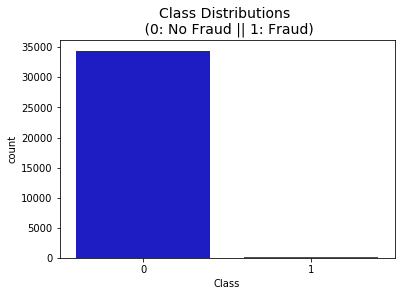

In [12]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df1, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

[162523.  40607.  64835. ... 108793. 132783. 122239.]


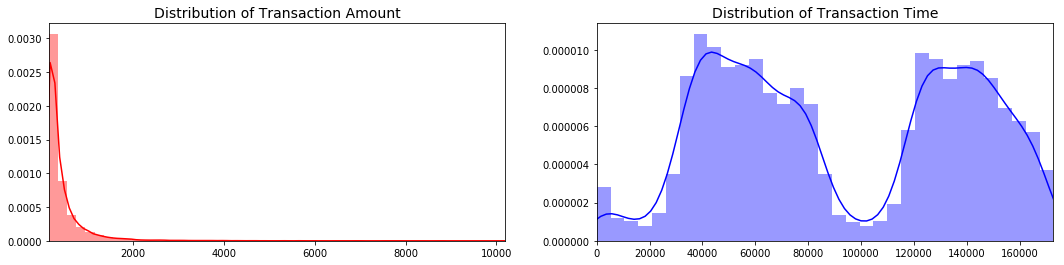

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df1['Amount'].values
time_val = df1['Time'].values

print(time_val)

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

# Data preprocessing : Scale time and amount

In [14]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df1['scaled_amount'] = rob_scaler.fit_transform(df1['Amount'].values.reshape(-1,1))
df1['scaled_time'] = rob_scaler.fit_transform(df1['Time'].values.reshape(-1,1))

df1.drop(['Time','Amount'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

In [15]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df2['scaled_amount'] = rob_scaler.fit_transform(df2['Amount'].values.reshape(-1,1))
df2['scaled_time'] = rob_scaler.fit_transform(df2['Time'].values.reshape(-1,1))

df2.drop(['Time','Amount'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

In [16]:
scaled_amount = df1['scaled_amount']
scaled_time = df1['scaled_time']

df1.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df1.insert(0, 'scaled_amount', scaled_amount)
df1.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df1.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
266881,0.311383,0.941849,-2.221556,1.261987,2.047642,4.659268,-0.535941,4.542044,-3.715525,-5.311701,-0.955321,0.200601,-1.342622,0.879905,0.241171,-0.365540,-1.735410,0.564495,0.380648,1.216692,1.872711,0.895990,-1.820388,0.873723,-2.648598,-0.162180,-0.492111,0.601490,0.627030,0.088289,0
41249,0.901709,-0.477198,0.271095,-2.720489,0.427427,-0.080256,-2.077311,0.334682,-0.620412,0.174167,0.087480,0.347286,0.319218,-0.528176,-1.560458,-0.281460,-1.103553,1.181354,0.433565,-0.623177,1.165483,1.068453,0.341998,-0.188797,-0.504412,0.027295,0.140939,-0.294037,-0.063847,0.102788,0
94333,0.286594,-0.195195,0.691001,-1.733548,-0.599416,-1.787779,-1.246370,-1.321640,0.417963,-0.421842,-0.208237,-0.423672,0.285488,0.546360,0.143878,0.575986,1.550274,-2.600045,0.674087,0.182842,-0.348666,0.199458,-0.430965,-1.506228,-0.098787,0.391298,0.117489,-0.318321,-0.053558,0.076598,0
141544,0.176078,0.032311,-0.962227,1.260166,0.239114,0.750526,-1.412022,0.655398,1.882536,0.035965,-1.143510,-0.322494,0.933652,0.921598,0.921342,0.561701,0.279237,0.179739,-0.510651,0.654422,0.819302,-0.232906,0.181970,0.637731,-0.076539,0.063102,-0.185953,-0.346645,-0.008349,-0.024787,0
6581,-0.220114,-0.856566,0.649933,-0.660716,1.283827,2.169457,-0.938512,0.546842,-0.285284,0.083293,2.374569,-0.908758,0.265053,-1.004837,2.109874,0.609445,-2.522206,-1.279179,1.589034,-1.237075,-0.225054,0.217546,-0.407082,-0.894580,-0.060158,0.365568,0.306398,-0.593129,0.029920,0.064128,0


In [17]:
scaled_amount = df2['scaled_amount']
scaled_time = df2['scaled_time']

df2.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df2.insert(0, 'scaled_amount', scaled_amount)
df2.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df2.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
17196,0.835071,-0.666804,1.226643,0.101988,-0.087072,0.111524,-0.281992,-1.356027,0.469050,-0.371725,-0.153672,-0.145105,-0.143505,0.320964,0.149313,0.452515,0.776253,0.028739,-0.177867,-1.004746,0.264953,0.019692,-0.355100,-1.153663,0.109793,0.420318,0.197932,0.699218,-0.114861,0.007583,0
139378,-0.312322,-0.024375,1.124848,0.125602,0.249962,0.489744,-0.040386,0.167561,-0.247614,0.284736,-0.067302,-0.170139,1.895117,0.507733,-1.008648,0.187249,1.021663,0.136320,0.370186,-0.573559,-0.625413,-0.204465,-0.192467,-0.576819,0.190343,-0.357451,0.000870,0.139971,-0.000993,0.011505,0
119668,-0.312322,-0.113640,-0.307902,1.003715,1.404277,0.592627,0.311014,-0.382106,0.531393,-0.015292,-0.758638,-0.511597,0.149643,0.245866,0.752802,-0.382214,1.590185,-0.332546,0.611852,-0.510495,0.563779,0.125220,-0.131802,-0.329268,0.046990,0.057413,-0.656960,0.193192,0.142038,0.157501,0
253676,1.157346,0.837134,2.174919,-1.535441,-0.726428,-1.430792,-1.517258,-0.751038,-1.155344,-0.180811,-1.111885,1.536101,-0.735705,-0.771714,0.238603,-0.447050,-0.085886,-0.568345,0.591162,-0.104975,-0.327292,-0.334351,-0.112766,0.050018,0.294666,1.123322,-0.306025,-0.241343,0.006553,-0.027567,0
161217,1.009953,0.338743,-0.335198,0.871378,0.632703,4.164242,1.702582,1.954354,0.396722,0.495056,-2.506020,1.609137,1.029249,-0.143569,-0.129187,0.862428,1.059507,-0.862144,0.597711,-0.509967,0.217672,0.260404,0.529635,1.473558,0.033413,-1.333266,-0.779961,0.595196,0.231547,0.193332,0


## Splitting the Data (Original DataFrame)
 1. original_Xtrain : Xtrain
 2. original_Ytrain : Ytrain
 3. original_Xtest : Xtest
 4. original_Ytest : Ytext

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df1['Class'].value_counts()[0]/len(df1) * 100,2), '% of the dataset')
print('Frauds', round(df1['Class'].value_counts()[1]/len(df1) * 100,2), '% of the dataset')

X = df1.drop('Class', axis=1)
y = df1['Class']
print(X.shape)
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.75 % of the dataset
Frauds 0.25 % of the dataset
(34523, 30)
Train: [ 6903  6904  6905 ... 34520 34521 34522] Test: [   0    1    2 ... 6919 7339 8326]
Train: [    0     1     2 ... 34520 34521 34522] Test: [ 6903  6904  6905 ... 13808 13809 14053]
Train: [    0     1     2 ... 34520 34521 34522] Test: [13810 13811 13812 ... 20712 21198 21570]
Train: [    0     1     2 ... 34520 34521 34522] Test: [20713 20714 20715 ... 27616 27617 27619]
Train: [    0     1     2 ... 27616 27617 27619] Test: [27618 27620 27621 ... 34520 34521 34522]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99750172 0.00249828]
[0.99753766 0.00246234]


## Random Under-Sampling : Let data balanced

In [19]:
df1 = df1.sample(frac=1)

# amount of fraud classes 86 rows.
fraud_df = df1.loc[df1['Class'] == 1]
non_fraud_df = df1.loc[df1['Class'] == 0][:100]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
237937,0.416662,0.789790,1.347741,-2.264573,-0.880366,-0.718927,-1.324611,0.116736,-0.684818,-0.014135,-0.295081,0.718430,1.135345,0.518409,0.986105,-0.332444,-0.061639,1.554142,-0.257209,-0.525132,0.364664,0.867114,0.700553,1.132899,-0.190553,0.780726,-0.355374,-0.161088,-0.060153,0.022953,0
143243,0.031557,0.041995,-2.226003,-2.036555,2.237854,-0.173280,0.156927,-0.203241,0.464436,-0.340063,-0.506997,0.376237,-0.866947,-0.867223,-0.763321,-0.642629,0.221954,-1.562050,-0.241173,1.150370,-2.051818,-0.370068,-0.264786,-0.018705,-0.074812,0.034110,0.478219,-0.351176,-0.273215,-0.239113,0
220276,-0.441112,0.704134,-0.371158,-0.995593,1.069708,-2.431163,-1.272188,-0.590400,0.125837,-0.136061,-1.909467,0.612274,-1.367258,-1.512129,-0.205645,-0.500458,-0.440674,-0.407477,0.369334,0.306032,-0.370053,-0.045305,0.026984,0.213236,0.256977,-0.032192,-0.334663,-0.222246,0.112134,0.171274,0
218166,1.537431,0.693589,-3.535204,0.143277,-0.165540,4.528986,-2.223197,4.539694,2.747405,0.631375,-1.714266,1.410995,0.561902,-0.115383,-0.015370,0.230046,0.749568,-0.036481,0.703006,-0.900592,1.193969,-1.436304,-0.985701,-0.552707,1.142494,-1.636207,0.191992,0.253466,0.591588,-0.358025,0
275624,-0.373544,0.989769,1.729496,-1.523605,-0.333122,0.169843,-1.482703,-0.256968,-0.768159,-0.002858,0.752574,0.402557,-1.540206,0.191496,-0.493086,-0.397256,-0.859352,-1.972938,0.347451,0.718779,-0.441669,-0.368867,-0.634966,-1.417745,0.324923,-0.101139,-0.556324,-0.664180,0.039313,-0.001454,0


In [20]:
df2 = df2.sample(frac=1)

# normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
normal_distributed_df = df2

# Shuffle dataframe rows
new_df2 = normal_distributed_df.sample(frac=1, random_state=42)

new_df2.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
275252,0.278199,0.955809,2.033125,-0.219438,-1.647962,-0.076795,0.450596,-0.275463,0.048083,-0.118781,0.152556,0.313232,0.658426,0.726838,0.189075,0.568192,0.042221,0.331887,-0.860760,0.292799,0.163416,-0.103667,0.246104,0.722522,0.000856,0.299494,0.086846,0.764053,-0.099704,-0.074540,0
221166,-0.312322,0.673639,2.052747,-0.092188,-1.075817,0.413504,-0.152693,-1.139710,0.139878,-0.283681,0.608005,0.077916,-0.767260,0.219649,-0.389120,0.370541,0.136708,-0.142686,-0.206009,-0.903406,0.077207,-0.259089,-0.288439,-0.712356,0.352169,-0.025512,-0.328717,0.202548,-0.070531,-0.061429,0
191106,-0.305213,0.516649,0.018542,0.734718,0.163233,-0.765490,0.549526,-0.646697,0.831795,0.012713,-0.143374,-0.213275,0.330947,0.238032,-0.927836,0.471010,-0.980342,0.238637,-0.723322,-0.037326,0.332495,-0.075214,-0.240109,-0.592695,0.028237,-0.367724,-0.507470,0.143726,0.236988,0.082155,0
190549,-0.323697,0.513873,-0.126321,0.818640,-1.684210,-1.578093,3.023074,3.258382,0.402508,0.828289,0.032277,0.046678,-0.161366,-0.075082,-0.253225,0.570132,0.900436,-0.533086,-0.563312,0.033214,-0.115634,0.174983,0.335508,1.185724,-0.087175,0.735419,-0.706131,-0.194429,0.635883,0.375254,0
229357,-0.252844,0.713989,0.154729,0.769665,-0.080956,-0.622251,0.954225,-0.512925,1.091686,-0.264430,-0.088507,0.102659,0.806717,0.325315,-0.461004,0.473726,-0.132156,-0.296272,-0.818169,0.698379,0.332406,0.073233,0.364018,1.399216,-0.134688,0.793008,-0.844141,-0.303320,0.334700,0.096071,0


##  Equally Distributing and Correlating: 
<a id="correlating"></a>
Now that we have our dataframe correctly balanced, we can go further with our <b>analysis</b> and <b>data preprocessing</b>.

Distribution of the Classes in the subsample dataset
0    0.537634
1    0.462366
Name: Class, dtype: float64


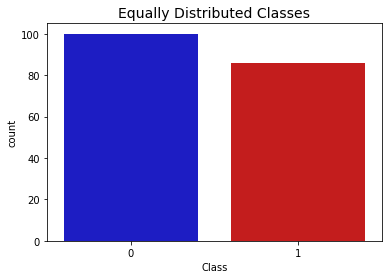

In [21]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))


sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

Distribution of the Classes in the subsample dataset
0    0.998377
1    0.001623
Name: Class, dtype: float64


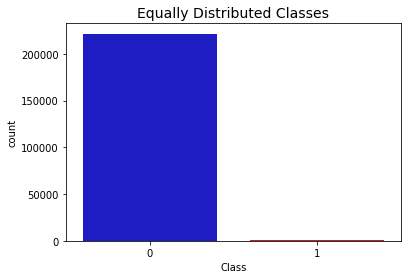

In [22]:
print('Distribution of the Classes in the subsample dataset')
print(new_df2['Class'].value_counts()/len(new_df2))



sns.countplot('Class', data=new_df2, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

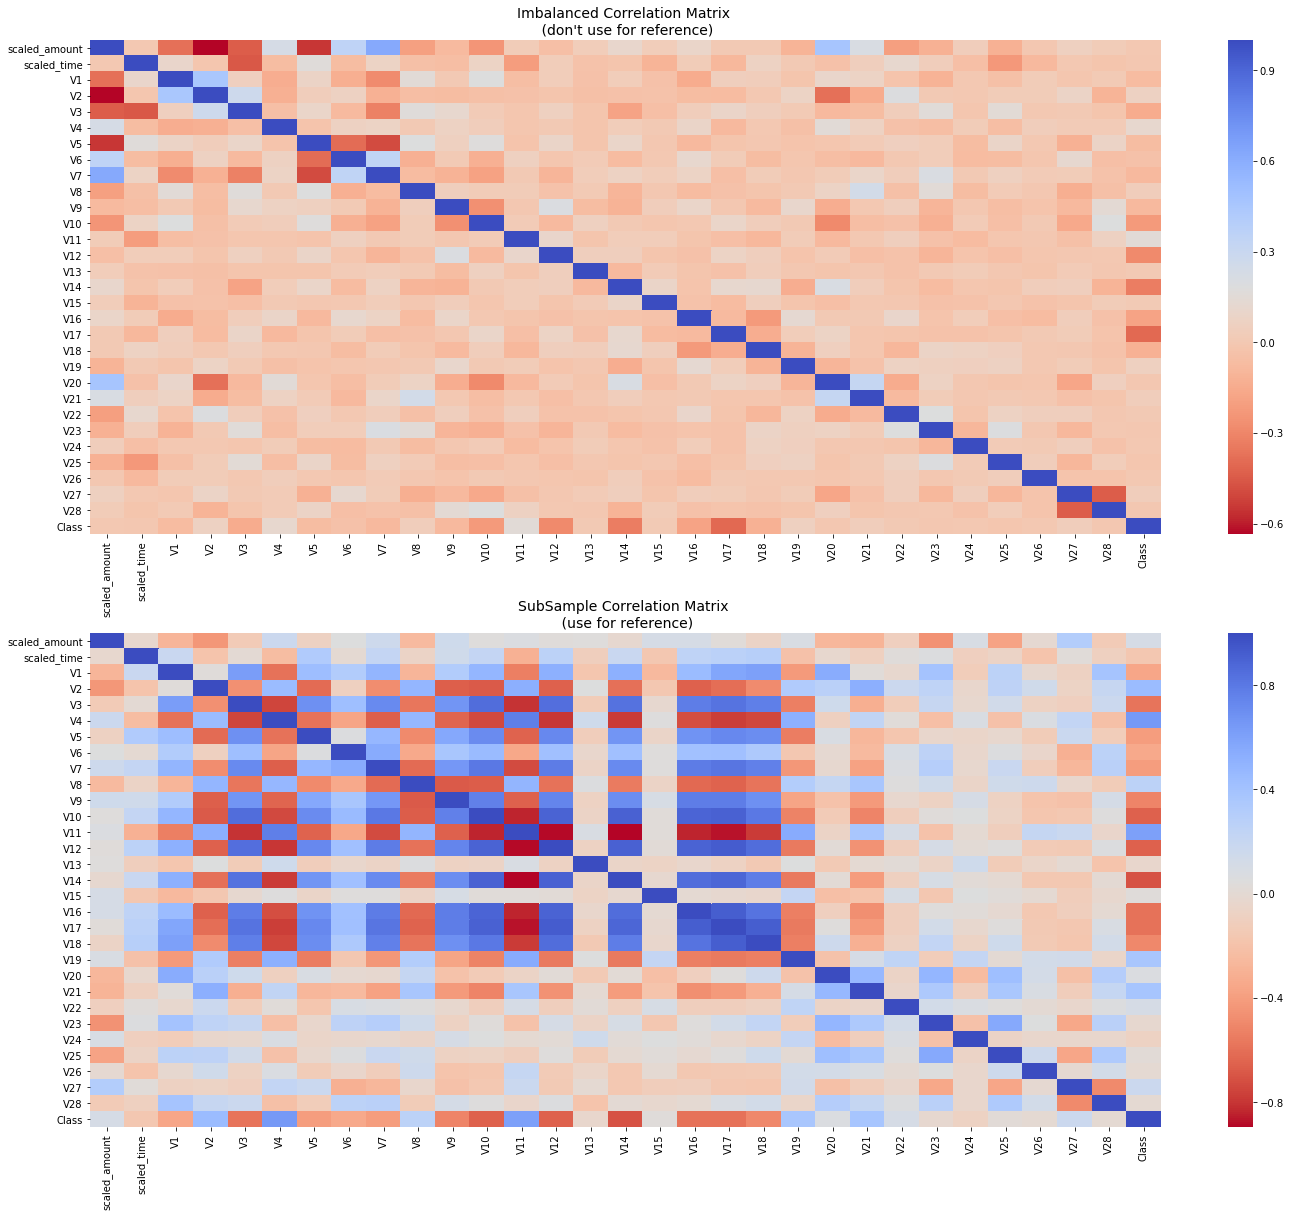

In [23]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df1.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

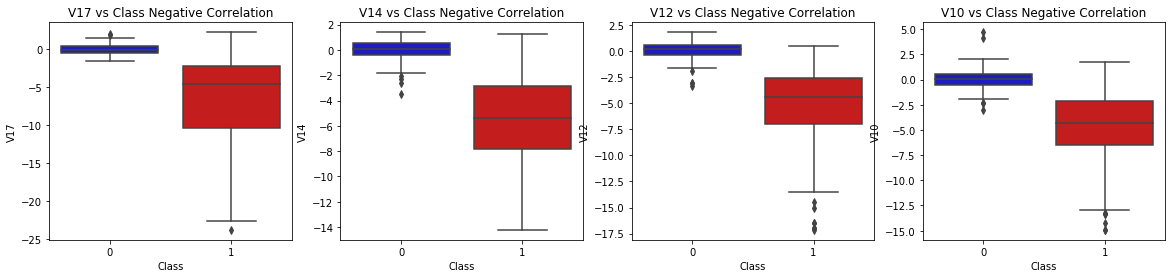

In [24]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

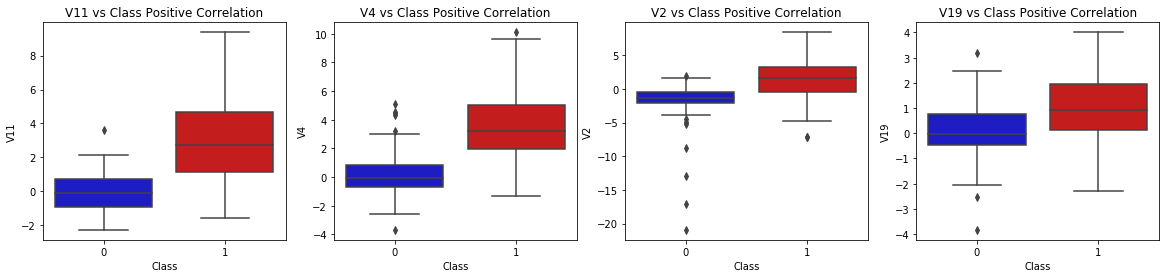

In [25]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

## Anomaly Detection:

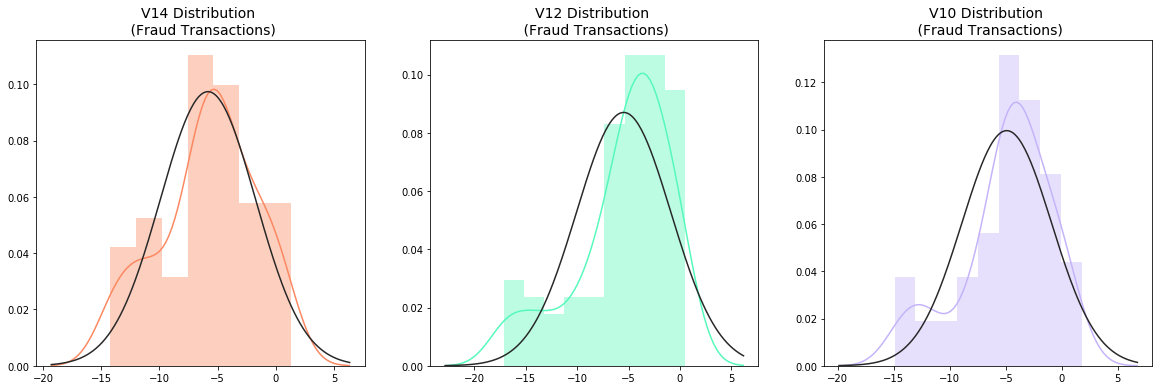

In [26]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [27]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -7.835919810801171 | Quartile 75: -2.84749730171425
iqr: 4.98842250908692
Cut Off: 7.48263376363038
V14 Lower: -15.31855357443155
V14 Upper: 4.6351364619161295
Feature V14 Outliers for Fraud Cases: 0
V10 outliers:[]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -13.558809500699912
V12 Upper: 3.972670558138798
V12 outliers: [-17.003289445516, -16.4655039422141, -15.0941631493865, -17.1504052507291, -16.4655039422141, -17.003289445516, -14.4686550955305]
Feature V12 Outliers for Fraud Cases: 7
Number of Instances after outliers removal: 179
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -11.306498471783701
V10 Upper: 3.778432756397821
V10 outliers: [-13.2151722995049, -12.835737682533901, -12.9389

In [28]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df2['V14'].loc[new_df2['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df2 = new_df2.drop(new_df2[(new_df2['V14'] > v14_upper) | (new_df2['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df2['V12'].loc[new_df2['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df2 = new_df2.drop(new_df2[(new_df2['V12'] > v12_upper) | (new_df2['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df2)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df2['V10'].loc[new_df2['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df2 = new_df2.drop(new_df2[(new_df2['V10'] > v10_upper) | (new_df2['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df2)))

Quartile 25: -9.867832597550484 | Quartile 75: -4.497855738348343
iqr: 5.369976859202141
Cut Off: 8.054965288803212
V14 Lower: -17.922797886353695
V14 Upper: 3.557109550454869
Feature V14 Outliers for Fraud Cases: 2
V10 outliers:[-18.4937733551053, -19.2143254902614]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -16.87289958910695
V12 Upper: 4.919288195262382
V12 outliers: [-18.047596570821604, -18.683714633344298, -18.553697009645802, -17.1829184301947, -17.1829184301947]
Feature V12 Outliers for Fraud Cases: 5
Number of Instances after outliers removal: 221491
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.716376612429444
V10 Upper: 4.501807755733635
V10 outliers: [-24.403184969972802, -23.228254835751

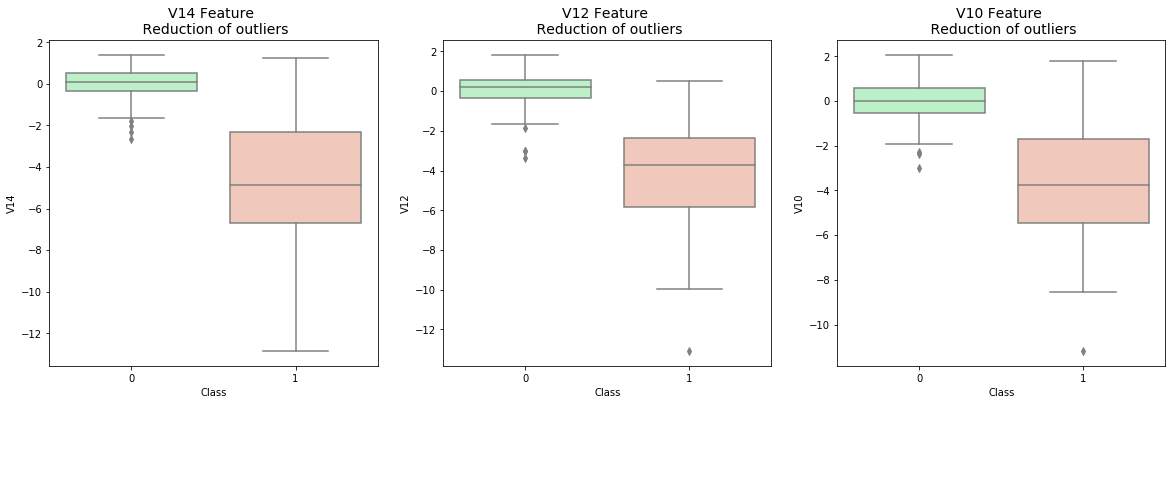

In [29]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

<h2>Dimensionality Reduction and Clustering: </h2>
<a id="clustering"></a>


In [31]:
print(new_df.shape)

(173, 31)


In [32]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
pca = PCA(n_components=2, random_state=42)
X_reduced_pca = pca.fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
tsvd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42)
X_reduced_svd = tsvd.fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

tsne.fit(X)
# 將 df2 降維至與 df1 相同的空間
# X2_reduced_tsne = tsne.transform(new_df2.drop('Class', axis=1))

T-SNE took 0.98 s
PCA took 0.0093 s
Truncated SVD took 0.0042 s


TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=30.0,
     random_state=42, verbose=0)

In [33]:
X.values

array([[ 0.41666242,  0.78978979,  1.34774063, ..., -0.16108833,
        -0.06015277,  0.02295342],
       [ 0.03155658,  0.04199548, -2.22600251, ..., -0.35117619,
        -0.27321488, -0.23911318],
       [-0.44111196,  0.70413437, -0.37115778, ..., -0.22224624,
         0.11213406,  0.17127352],
       ...,
       [-0.28468928,  0.6207603 ,  1.65826459, ...,  0.69232338,
        -0.08165631, -0.02149295],
       [ 2.4221032 , -0.09435016, -3.21112793, ..., -0.13158149,
        -0.15644862,  0.03613428],
       [ 3.15688175, -0.25911958, -7.9368747 , ...,  0.66462869,
        -2.74323333,  2.82496088]])

In [34]:
# X2.values.shape

(173,)


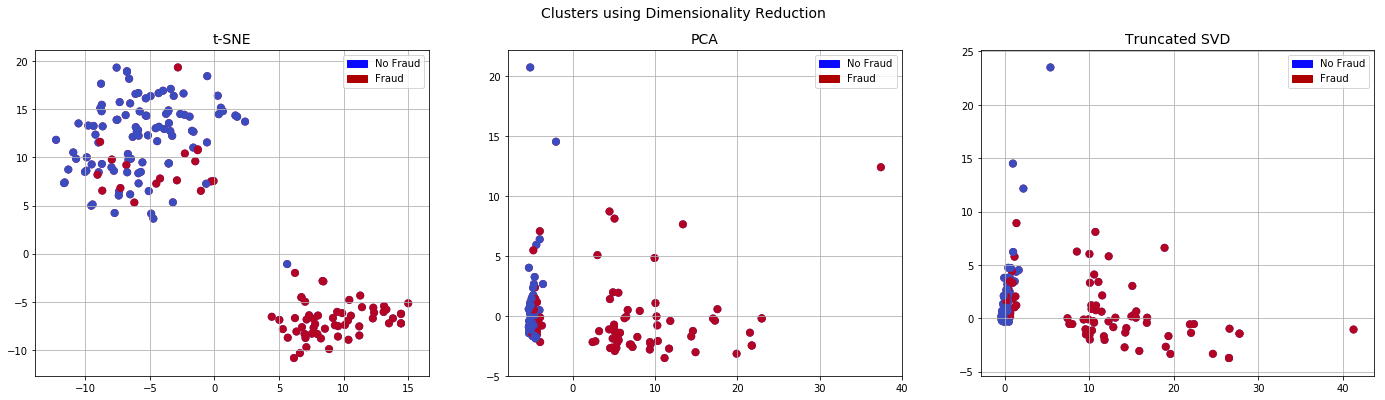

In [35]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# # t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

print( X_reduced_pca[:,1].shape)
# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

(220008, 30)


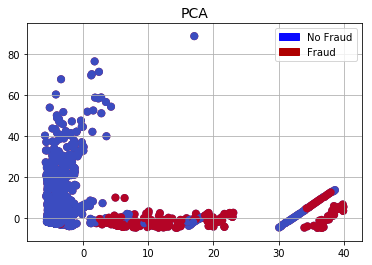

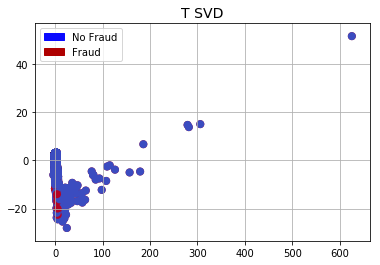

In [36]:
import matplotlib.pyplot as plt

# 將 PCA 方程式應用於 df2 資料集
X2 = new_df2.iloc[:, :30]  # 假設特徵欄位從第 1 到第 28 欄位
y2 = new_df2['Class']
# 使用之前訓練好的 PCA 模型進行轉換

# X2_reduced_tsne = tsne.fit_transform(X2)
X2_reduced_pca = pca.transform(X2)
X2_reduced_tsvd = tsvd.fit_transform(X2)

print(X2.shape)



# TSNE scatter plot
# plt.scatter(X2_reduced_tsne[:, 0], X2_reduced_tsne[:, 1], c=(y2 == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
# plt.scatter(X2_reduced_tsne[:, 0], X2_reduced_tsne[:, 1], c=(y2 == 1), cmap='coolwarm', label='Fraud', linewidths=2)
# plt.title('TSNE', fontsize=14)
# plt.grid(True)
# plt.legend(handles=[blue_patch, red_patch])
# plt.show()

# 取得 PCA 投影的前兩個主成分
PC1 = X2_reduced_pca[:, 0]
PC2 = X2_reduced_pca[:, 1]

# PCA scatter plot
plt.scatter(PC1, PC2, c=(y2 == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(PC1, PC2, c=(y2 == 1), cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('PCA', fontsize=14)
plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])
plt.show()

# tsvd scatter plot
plt.scatter(X2_reduced_tsvd[:, 0], X2_reduced_tsvd[:, 1], c=(y2 == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X2_reduced_tsvd[:, 0], X2_reduced_tsvd[:, 1], c=(y2 == 1), cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('T SVD', fontsize=14)
plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])
plt.show()



In [37]:
# X2_reduced_tsne = tsne.fit_transform(X2)
# ㄌ# TSNE scatter plot
# plt.scatter(X2_reduced_tsne[:, 0], X2_reduced_tsne[:, 1], c=(y2 == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
# plt.scatter(X2_reduced_tsne[:, 0], X2_reduced_tsne[:, 1], c=(y2 == 1), cmap='coolwarm', label='Fraud', linewidths=2)
# plt.title('TSNE', fontsize=14)
# plt.grid(True)
# plt.legend(handles=[blue_patch, red_patch])
# plt.show()

In [38]:
print(X2.shape)

(220008, 30)


# 閾值內資料的pca

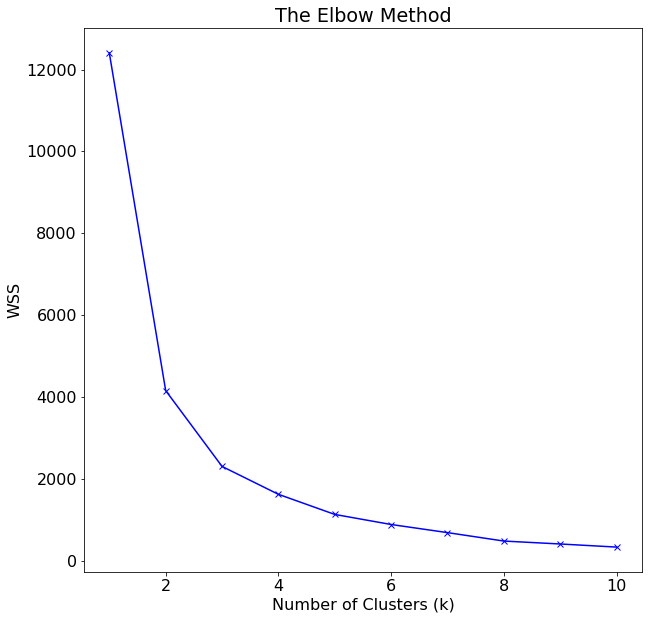

In [39]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 設置KMeans的K值範圍
K = range(1, 11)

# 計算每個K值對應的WSS值
wss = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_reduced_pca)
    wss.append(kmeans.inertia_)

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 16

# 繪製WSS vs. K曲線
plt.plot(K, wss, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSS')
plt.title('The Elbow Method')
plt.show()

In [40]:
from sklearn.cluster import KMeans
import numpy as np

# 加載數據，假設你的數據存儲在data變量中
data = X_reduced_pca

# 創建KMeans對象，指定分為3群
kmeans = KMeans(n_clusters=4)

# 使用KMeans對數據進行聚類
kmeans.fit(data)

# 獲取每個數據點所屬的群
labels = kmeans.labels_

# 從每個群中隨機抽樣3000個點
num_samples = 50
samples = []
for i in range(4):
    # 獲取第i個群的所有數據點
    cluster_data = data[labels == i]
    
    # 如果該群的數據點數量小於3000，直接將所有數據點加入樣本集合中
    if len(cluster_data) <= num_samples:
        samples.extend(cluster_data)
    else:
        # 從該群中隨機抽樣3000個數據點
        sample_indices = np.random.choice(len(cluster_data), num_samples, replace=False)
        samples.extend(cluster_data[sample_indices])


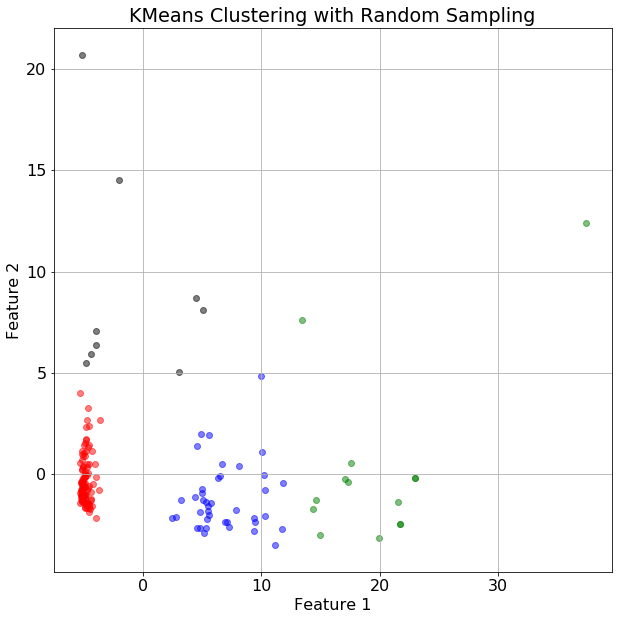

In [41]:
import matplotlib.pyplot as plt

# 定義3種不同顏色，分別代表3個群
colors = ['red', 'green', 'blue', 'k']

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 16


# 畫出散點圖，標記每個數據點所屬的群
for i in range(4):
    cluster_data = data[labels == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=colors[i], alpha=0.5)

# 加上格線
plt.grid(True)

# 設置圖片標題和坐標軸標籤
plt.title('KMeans Clustering with Random Sampling')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# PCA 

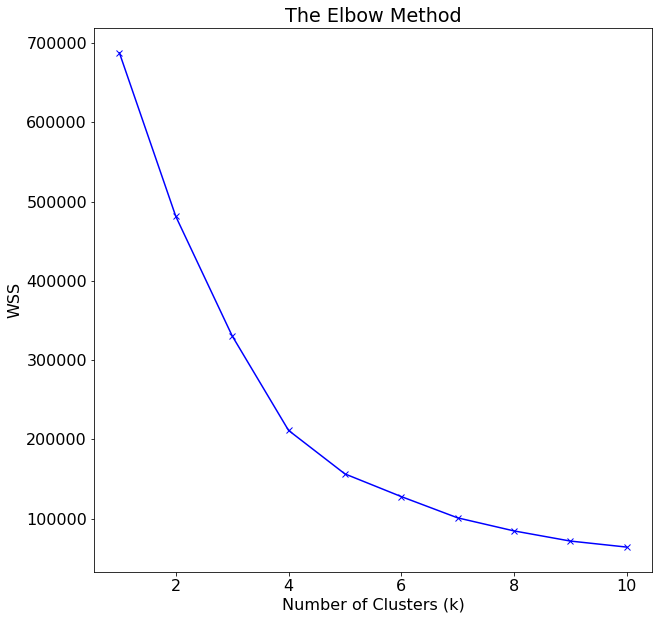

In [42]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 設置KMeans的K值範圍
K = range(1, 11)

# 計算每個K值對應的WSS值
wss = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X2_reduced_pca)
    wss.append(kmeans.inertia_)

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 16

# 繪製WSS vs. K曲線
plt.plot(K, wss, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSS')
plt.title('The Elbow Method')
plt.show()

In [43]:
from sklearn.cluster import KMeans
import numpy as np

# 加載數據，假設你的數據存儲在data變量中
data_pca = X2_reduced_pca

# 創建KMeans對象，指定分為3群
kmeans = KMeans(n_clusters=8)

# 使用KMeans對數據進行聚類
kmeans.fit(data_pca)

# 獲取每個數據點所屬的群
labels = kmeans.labels_

# 從每個群中隨機抽樣3000個點
num_samples = 50
samples = []
for i in range(8):
    # 獲取第i個群的所有數據點
    cluster_data = data_pca[labels == i]
    
    # 如果該群的數據點數量小於3000，直接將所有數據點加入樣本集合中
    if len(cluster_data) <= num_samples:
        samples.extend(cluster_data)
    else:
        # 從該群中隨機抽樣3000個數據點
        sample_indices = np.random.choice(len(cluster_data), num_samples, replace=False)
        samples.extend(cluster_data[sample_indices])

Cluster 0: 65515 samples
Cluster 1: 142256 samples
Cluster 2: 1495 samples
Cluster 3: 77 samples
Cluster 4: 156 samples
Cluster 5: 230 samples
Cluster 6: 10229 samples
Cluster 7: 50 samples


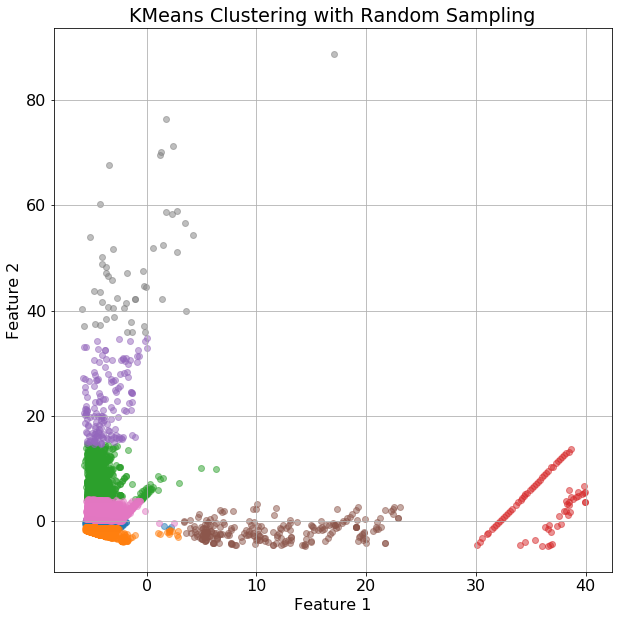

In [44]:
import matplotlib.pyplot as plt

# 定義3種不同顏色，分別代表3個群
# colors = ['red', 'green', 'blue']

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 16


# 畫出散點圖，標記每個數據點所屬的群
for i in range(8):
    cluster_data = data_pca[labels == i]
    print(f"Cluster {i}: {cluster_data.shape[0]} samples")
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], alpha=0.5)

# 加上格線
plt.grid(True)

# 設置圖片標題和坐標軸標籤
plt.title('KMeans Clustering with Random Sampling')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
# plt.xlim(-10, 30)
# plt.ylim(-10, 30)
plt.show()

# 把PCADF cluster 和他的 Class分在一起

Cluster 0: 65515 samples, 7 frauds (0.01%), 65508 non-frauds (99.99%)
Cluster 1: 142256 samples, 63 frauds (0.04%), 142193 non-frauds (99.96%)
Cluster 2: 1495 samples, 6 frauds (0.40%), 1489 non-frauds (99.60%)
Cluster 3: 77 samples, 54 frauds (70.13%), 23 non-frauds (29.87%)
Cluster 4: 156 samples, 0 frauds (0.00%), 156 non-frauds (100.00%)
Cluster 5: 230 samples, 199 frauds (86.52%), 31 non-frauds (13.48%)
Cluster 6: 10229 samples, 3 frauds (0.03%), 10226 non-frauds (99.97%)
Cluster 7: 50 samples, 0 frauds (0.00%), 50 non-frauds (100.00%)


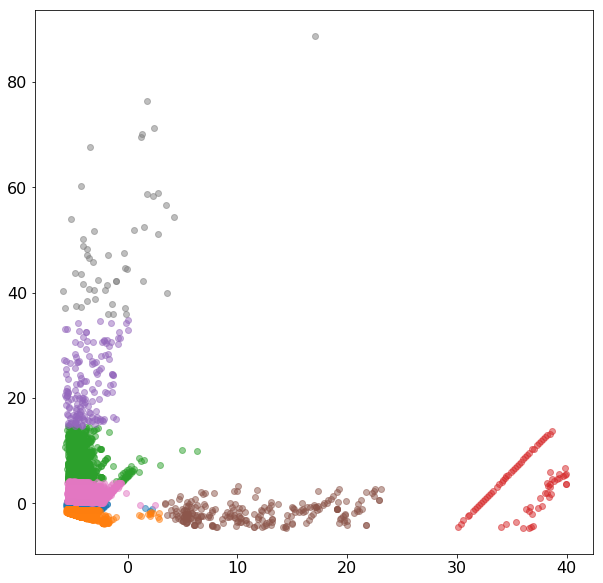

In [45]:
cluster_data_with_label = []

for i in range(8):
    cluster_data = data_pca[labels == i]
    cluster_y = y2[labels == i]
    # 添加分类特征列
    cluster_data_with_label_i = np.c_[cluster_data, np.ones(cluster_data.shape[0]) * i]
    cluster_data_with_label += cluster_data_with_label_i.tolist()
    n_samples = cluster_y.shape[0]
    n_frauds = np.sum(cluster_y == 1)
    n_non_frauds = np.sum(cluster_y == 0)
    print(f"Cluster {i}: {n_samples} samples, {n_frauds} frauds ({n_frauds/n_samples*100:.2f}%), {n_non_frauds} non-frauds ({n_non_frauds/n_samples*100:.2f}%)")
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], alpha=0.5)
    
pcadf = pd.DataFrame(cluster_data_with_label,columns=["Feature 1", "Feature 2", "Cluster"])


Cluster 0: 65515 samples, 7 frauds (0.01%), 65508 non-frauds (99.99%)
Cluster 1: 142256 samples, 63 frauds (0.04%), 142193 non-frauds (99.96%)
Cluster 2: 1495 samples, 6 frauds (0.40%), 1489 non-frauds (99.60%)
Cluster 3: 77 samples, 54 frauds (70.13%), 23 non-frauds (29.87%)
Cluster 4: 156 samples, 0 frauds (0.00%), 156 non-frauds (100.00%)
Cluster 5: 230 samples, 199 frauds (86.52%), 31 non-frauds (13.48%)
Cluster 6: 10229 samples, 3 frauds (0.03%), 10226 non-frauds (99.97%)
Cluster 7: 50 samples, 0 frauds (0.00%), 50 non-frauds (100.00%)
        Feature 1  Feature 2  Cluster  Class
0       -4.545832  -0.337652      0.0    0.0
1       -5.209076  -1.091114      0.0    0.0
2       -4.597025  -0.874009      0.0    0.0
3       -5.231019  -0.448454      0.0    0.0
4       -5.089860  -0.695489      0.0    0.0
5       -4.831018  -1.050230      0.0    0.0
6       -5.156021  -1.104826      0.0    0.0
7       -4.945567  -0.699241      0.0    0.0
8       -4.711648  -0.703769      0.0    0.0
9  

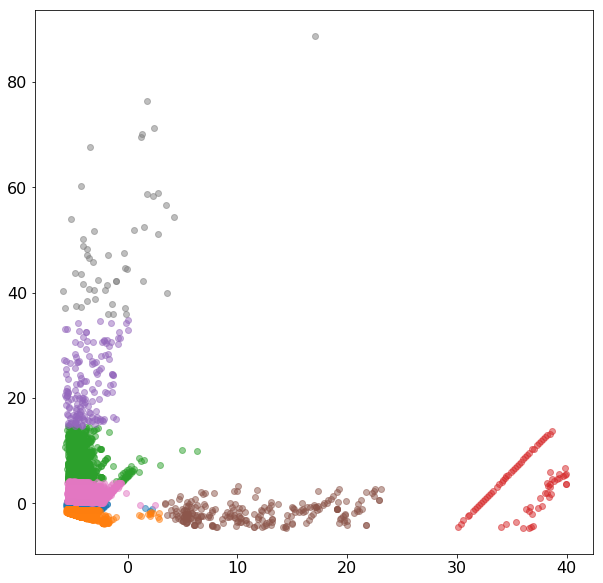

In [46]:
import pandas as pd
import numpy as np

cluster_data_with_label = []

for i in range(8):
    cluster_data = data_pca[labels == i]
    cluster_y = y2[labels == i]
    # 添加分类特征列
    cluster_data_with_label_i = np.c_[cluster_data, np.ones(cluster_data.shape[0]) * i, cluster_y]
    cluster_data_with_label += cluster_data_with_label_i.tolist()
    n_samples = cluster_y.shape[0]
    n_frauds = np.sum(cluster_y == 1)
    n_non_frauds = np.sum(cluster_y == 0)
    print(f"Cluster {i}: {n_samples} samples, {n_frauds} frauds ({n_frauds/n_samples*100:.2f}%), {n_non_frauds} non-frauds ({n_non_frauds/n_samples*100:.2f}%)")
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], alpha=0.5)

pcadf = pd.DataFrame(cluster_data_with_label, columns=["Feature 1", "Feature 2", "Cluster", "Class"])

print(pcadf)

In [47]:
# 驗證一下到底對不對
cluster_ratios = pcadf.groupby('Cluster')['Class'].mean() * 100
print(cluster_ratios)

Cluster
0.0     0.010685
1.0     0.044286
2.0     0.401338
3.0    70.129870
4.0     0.000000
5.0    86.521739
6.0     0.029328
7.0     0.000000
Name: Class, dtype: float64


In [48]:
old_df = pcadf

# 创建新的DataFrame用于存储移动的样本
new_df = pd.DataFrame(columns=pcadf.columns)

# 从pcadf中随机抽取100个数据
random_samples = pcadf.sample(n=100)

# 将抽取的数据从pcadf中移除，并添加到new_df中
for _, sample in random_samples.iterrows():
    cluster = int(sample['Cluster'])
    new_df = new_df.append(sample)
    pcadf = pcadf.drop(index=sample.name)

# 重置索引
new_df.reset_index(drop=True, inplace=True)
pcadf.reset_index(drop=True, inplace=True)

# 打印新的DataFrame
print(new_df)
print(len(new_df))

    Feature 1  Feature 2  Cluster  Class
0   -5.009971  -1.439837      1.0    0.0
1   -5.000396  -1.738359      1.0    0.0
2   -4.985666  -1.928473      1.0    0.0
3   -4.891635  -1.200848      0.0    0.0
4   -4.785544  -1.452497      1.0    0.0
5   -4.679925  -1.084254      0.0    0.0
6   -5.108276  -1.797948      1.0    0.0
7   -5.004561  -0.657529      0.0    0.0
8   -5.161587  -1.694916      1.0    0.0
9   -4.760994  -1.663564      1.0    0.0
10  -5.041229   0.115038      0.0    0.0
11  -4.710193  -1.579479      1.0    0.0
12  -4.732140  -1.361607      1.0    0.0
13  -4.984473  -1.141293      0.0    0.0
14  -4.482184  -0.287529      0.0    0.0
15  -4.706451   0.283019      6.0    0.0
16  -4.519082  -1.172693      0.0    0.0
17  -3.684447   5.044986      2.0    0.0
18  -4.321620  -0.714883      0.0    0.0
19  -4.393128  -2.026685      1.0    0.0
20  -4.967166  -0.638094      0.0    0.0
21  -4.814157  -1.512186      1.0    0.0
22  -4.786243   1.062980      6.0    0.0
23  -4.987341  -

# 依照機率選擇分群（效果差）

In [49]:
old_df = pcadf

# 创建新的DataFrame用于存储移动的样本
new_df = pd.DataFrame(columns=pcadf.columns)

# 从pcadf中随机抽取100个数据
random_samples = pcadf.sample(n=100)

# 将抽取的数据从pcadf中移除，并添加到new_df中
for _, sample in random_samples.iterrows():
    cluster = int(sample['Cluster'])
    new_df = new_df.append(sample)
    pcadf = pcadf.drop(index=sample.name)

# 重置索引
new_df.reset_index(drop=True, inplace=True)
pcadf.reset_index(drop=True, inplace=True)

# 打印新的DataFrame
print(new_df)
print(len(new_df))

    Feature 1  Feature 2  Cluster  Class
0   -5.221286  -0.889876      0.0    0.0
1   -5.142261   1.894650      6.0    0.0
2   -4.628284  -0.735558      0.0    0.0
3   -4.788555  -1.683071      1.0    0.0
4   -5.009810  -1.692548      1.0    0.0
5   -4.046803  -1.225101      0.0    0.0
6   -4.797867  -0.604142      0.0    0.0
7   -4.994551  -1.756691      1.0    0.0
8   -4.846230  -1.511349      1.0    0.0
9   -5.166046  -0.722419      0.0    0.0
10  -5.207194  -1.622500      1.0    0.0
11  -4.731497  -1.127128      0.0    0.0
12  -4.981650  -1.735003      1.0    0.0
13  -5.109016  -1.620173      1.0    0.0
14  -5.208142  -1.687753      1.0    0.0
15  -3.766098  -1.225728      0.0    0.0
16  -5.046504  -0.317677      0.0    0.0
17  -4.629141  -1.220624      0.0    0.0
18  -5.099726  -1.689770      1.0    0.0
19  -4.848483  -1.505729      1.0    0.0
20  -5.162315  -1.330363      1.0    0.0
21  -5.037331  -0.997655      0.0    0.0
22  -4.972497  -0.919980      0.0    0.0
23  -5.088965  -

In [51]:
import pandas as pd

# 合并两个数据框
merged_df = pd.concat([pcadf, y2], axis=1)

# 根据 Cluster 列进行分组，并计算每个类别中标签为 1 的数量
grouped_df = merged_df.groupby('Cluster')['Class'].sum()

# 找出标签为 1 最多的类别
max_label_1_cluster = grouped_df.idxmax()

# 输出结果
print("Proportion of label 1 in each cluster:")
print(grouped_df)

Proportion of label 1 in each cluster:
Cluster       
0.0      Class      7.0
         Class    134.0
1.0      Class     63.0
         Class    128.0
2.0      Class      6.0
         Class      1.0
3.0      Class     54.0
         Class      0.0
4.0      Class      0.0
         Class      0.0
5.0      Class    198.0
         Class      0.0
6.0      Class      3.0
         Class      5.0
7.0      Class      0.0
         Class      0.0
Name: Class, dtype: float64


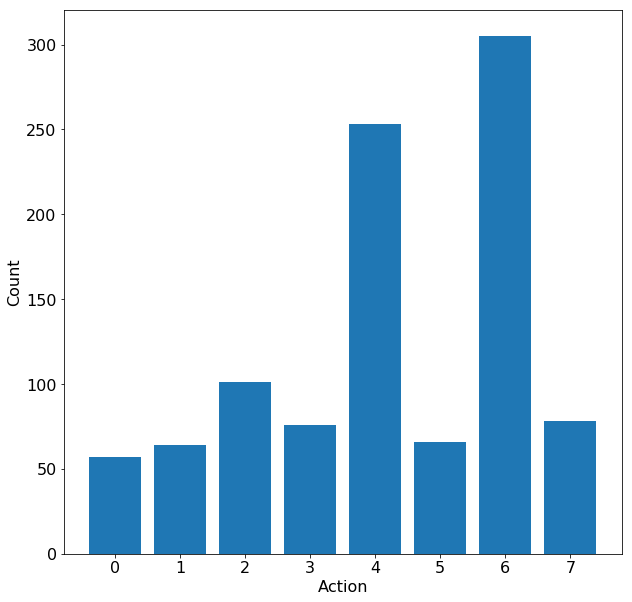

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# 定义多臂老虎机类
class Bandit:
    def __init__(self, true_prob):
        self.true_prob = true_prob
        self.num_actions = len(true_prob)
    
    def pull_arm(self, arm):
        reward = np.random.binomial(1, self.true_prob[arm])
        return reward

# 初始化多臂老虎机
true_probs = [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
bandit = Bandit(true_probs)

# 定义ε-greedy算法函数
def epsilon_greedy(bandit, num_iterations, epsilon):
    num_actions = bandit.num_actions
    num_rewards = np.zeros(num_actions)
    sum_rewards = np.zeros(num_actions)
    average_rewards = np.zeros(num_actions)
    chosen_actions = []
    
    for t in range(num_iterations):
        # 选择动作
        if np.random.random() < epsilon:
            action = np.random.randint(num_actions)
        else:
            action = np.argmax(average_rewards)
        
        # 执行动作并获取奖励
        reward = bandit.pull_arm(action)
        
        # 更新动作的统计信息
        num_rewards[action] += 1
        sum_rewards[action] += reward
        average_rewards[action] = sum_rewards[action] / num_rewards[action]
        
        # 记录选择的动作
        chosen_actions.append(action)
    
    return chosen_actions

# 运行ε-greedy算法并获得选择的动作序列
num_iterations = 1000
epsilon = 0.4
chosen_actions = epsilon_greedy(bandit, num_iterations, epsilon)

# 绘制动作选择分布图
action_counts = np.bincount(chosen_actions)
plt.bar(range(len(action_counts)), action_counts)
plt.xlabel('Action')
plt.ylabel('Count')
plt.xticks(range(len(action_counts)))
plt.show()


# TSVD (壞方法)

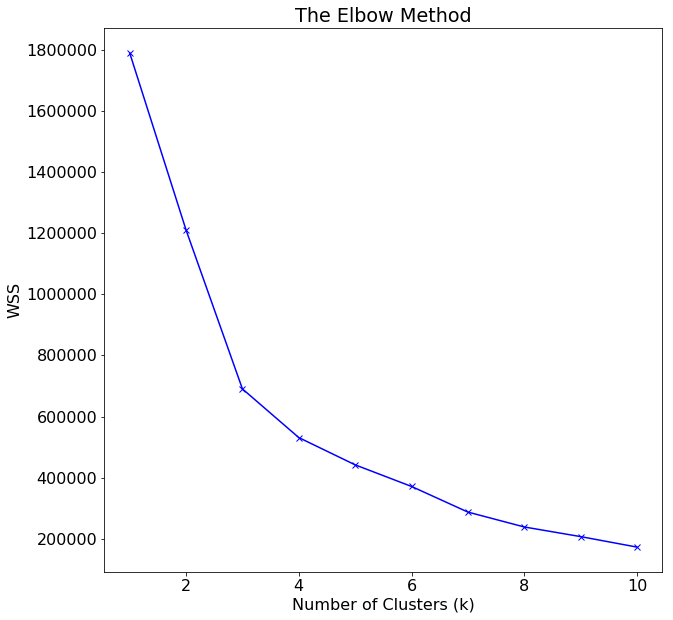

In [54]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 設置KMeans的K值範圍
K = range(1, 11)

# 計算每個K值對應的WSS值
wss = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X2_reduced_tsvd)
    wss.append(kmeans.inertia_)

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 16

# 繪製WSS vs. K曲線
plt.plot(K, wss, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSS')
plt.title('The Elbow Method')
plt.show()

In [55]:
from sklearn.cluster import KMeans
import numpy as np

# 加載數據，假設你的數據存儲在data變量中
data = X2_reduced_tsvd

# 創建KMeans對象，指定分為3群
kmeans = KMeans(n_clusters=8)

# 使用KMeans對數據進行聚類
kmeans.fit(data)

# 獲取每個數據點所屬的群
labels = kmeans.labels_

# 從每個群中隨機抽樣3000個點
num_samples = 50
samples = []
for i in range(8):
    # 獲取第i個群的所有數據點
    cluster_data = data[labels == i]
    
    # 如果該群的數據點數量小於3000，直接將所有數據點加入樣本集合中
    if len(cluster_data) <= num_samples:
        samples.extend(cluster_data)
    else:
        # 從該群中隨機抽樣3000個數據點
        sample_indices = np.random.choice(len(cluster_data), num_samples, replace=False)
        samples.extend(cluster_data[sample_indices])

Cluster 0: 77262 samples
Cluster 1: 87075 samples
Cluster 2: 6 samples
Cluster 3: 8064 samples
Cluster 4: 1 samples
Cluster 5: 22 samples
Cluster 6: 25719 samples
Cluster 7: 21859 samples


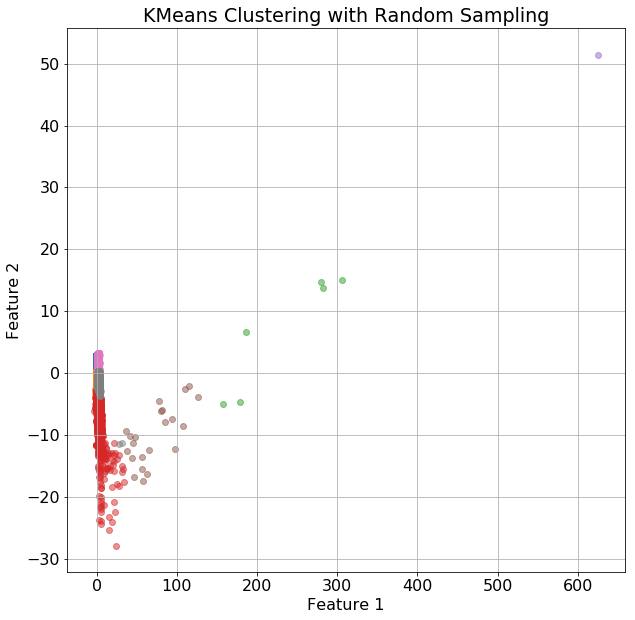

In [56]:
import matplotlib.pyplot as plt

# 定義3種不同顏色，分別代表3個群
# colors = ['red', 'green', 'blue']

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 16


# 畫出散點圖，標記每個數據點所屬的群
for i in range(8):
    cluster_data = data[labels == i]
    print(f"Cluster {i}: {cluster_data.shape[0]} samples")
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], alpha=0.5)

# 加上格線
plt.grid(True)

# 設置圖片標題和坐標軸標籤
plt.title('KMeans Clustering with Random Sampling')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
# plt.xlim(-10, 30)
# plt.ylim(-10, 30)
plt.show()

In [57]:
for i in range(8):
    cluster_data = data[labels == i]
    cluster_y = y2[labels == i]
    n_samples = cluster_y.shape[0]
    n_frauds = np.sum(cluster_y == 1)
    n_non_frauds = np.sum(cluster_y == 0)
    print(f"Cluster {i}: {n_samples} samples, {n_frauds} frauds ({n_frauds/n_samples*100:.2f}%), {n_non_frauds} non-frauds ({n_non_frauds/n_samples*100:.2f}%)")
#     plt.scatter(cluster_data[:, 0], cluster_data[:, 1], alpha=0.5)

Cluster 0: 77262 samples, 80 frauds (0.10%), 77182 non-frauds (99.90%)
Cluster 1: 87075 samples, 104 frauds (0.12%), 86971 non-frauds (99.88%)
Cluster 2: 6 samples, 0 frauds (0.00%), 6 non-frauds (100.00%)
Cluster 3: 8064 samples, 122 frauds (1.51%), 7942 non-frauds (98.49%)
Cluster 4: 1 samples, 0 frauds (0.00%), 1 non-frauds (100.00%)
Cluster 5: 22 samples, 0 frauds (0.00%), 22 non-frauds (100.00%)
Cluster 6: 25719 samples, 10 frauds (0.04%), 25709 non-frauds (99.96%)
Cluster 7: 21859 samples, 16 frauds (0.07%), 21843 non-frauds (99.93%)
